In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from pdb import set_trace as breakpoint
from time import time

import numpy as np
import matplotlib.pyplot as plt

from datasets.generators1d import * 
from datasets.settings import OMEGA, MU0, EPSILON0, SCALE, C, L0, PIXEL_SIZE
from models.utils import pbar, tensor_diff, tensor_roll

In [2]:
device = torch.device('cuda:0')

In [71]:
class MaxwellDense(nn.Module):
    
    def __init__(self, size=64, src_x=32, use_A_phi=False):
        super().__init__()
        
        self.size = size
        self.src_x = src_x
        self.use_A_phi = use_A_phi

#         self.layer_dims = [self.size, 128, 256, 512, 512, 256, self.size]
        self.layer_dims = [self.size]+[2048]*6+[self.size]

        layers_amp = []
        layers_phi = []
        for i in range(len(self.layer_dims) - 1):
            layers_amp.append(nn.Linear(self.layer_dims[i], self.layer_dims[i+1]))
            layers_phi.append(nn.Linear(self.layer_dims[i], self.layer_dims[i+1]))
            
        self.layers_amp = nn.ModuleList(layers_amp)
        if self.use_A_phi:
            self.layers_phi = nn.ModuleList(layers_phi)
        
    def forward_amplitude_phase(self, x):
        A = x
        imax = len(self.layers_amp) - 1
        for i, layer in enumerate(self.layers_amp):
            A = layer(A)
            if i < imax:
                A = nn.ReLU()(A)
            else:
                A = nn.ELU()(A) + 1
                
        phi = x
        imax = len(self.layers_phi) - 1
        for i, layer in enumerate(self.layers_phi):
            phi = layer(phi)
            if i < imax:
                phi = nn.ReLU()(phi)
            else:
                phi = 2 * np.pi * nn.Tanh()(phi)
        
        return A, phi
    
    def get_fields(self, epsilons, add_zero_bc=False):
        # Get amplitude and phase vectors
        if not self.use_A_phi:
            A = epsilons
            imax = len(self.layers_amp) - 1
            for i, layer in enumerate(self.layers_amp):
                A = layer(A)
                if i < imax:
                    A = nn.ReLU()(A)
            return A
            
        A, phi = self.forward_amplitude_phase(epsilons)
            
        # Combine to form waveform
        x = (PIXEL_SIZE * (torch.arange(self.size, dtype=torch.float, device=device) - self.src_x))
        fields = A * torch.cos(OMEGA / C * torch.sqrt(epsilons) * x + phi)
        
        if add_zero_bc:
            batch_size, _ = epsilons.shape
            zero = torch.zeros((batch_size, 1), device=device)  
            fields = torch.cat([zero, fields, zero], dim=-1)
            
        return fields
    
    def forward(self, epsilons):        
        # Compute Ez fields
        fields = self.get_fields(epsilons)
        
        batch_size, _ = epsilons.shape

        # Add zero field amplitudes at edge points for resonator BC's
        zero = torch.zeros((batch_size, 1), device=device)
        E = torch.cat([zero, fields, zero], dim=-1)

        # Add first layer of cavity BC's
        barrier = torch.full((batch_size, 1), -1e10, device=device)
        eps = torch.cat([barrier, epsilons, barrier], dim=-1)

        # Compute Maxwell operator on fields
        diffs = tensor_diff(E, n=2, padding=None)
        curl_curl_E = (SCALE / PIXEL_SIZE**2) * torch.cat([zero, diffs, zero], dim=-1)
        epsilon_E = (SCALE * -OMEGA**2 * MU0 * EPSILON0) * eps * E

        # Compute free-current vector
        J = torch.zeros_like(E)
        J[:,self.src_x + 1] = 1.526814027933079

        out = curl_curl_E - epsilon_E - J

        return out

In [72]:
def neural_field_solve(epsilons, src_x=32, target_loss=1e-5, max_epochs=1e4):
    model = MaxwellDense(size=len(epsilons)).to(device)
    criterion = nn.MSELoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
    epsilons = torch.tensor([epsilons]).float().to(device)
    
    epochs = 0
    loss=1e10
    model.train()
    p = pbar(total=max_epochs)
    while loss > target_loss and epochs <= max_epochs:
        epochs += 1
        outputs = model(epsilons)
        loss = criterion(outputs, torch.zeros_like(outputs))
        optimizer.zero_grad()
        loss.backward()        
        optimizer.step()
        p.update()
        p.set_description("ℒ = {:.1e}".format(loss.item()), refresh=False)
    
    p.close()
    
    model.eval()        
    return model.get_fields(epsilons)[0].cpu().detach().numpy(), model(epsilons)[0].cpu().detach().numpy()

In [73]:
def neural_solve_plot(epsilons, target_loss=1e-5, max_epochs=1e4):
    start = time()
    _, src_x, Hx, Hy, Ez = Cavity1D(device_length=len(epsilons), cavity_buffer=16).solve(epsilons, omega=OMEGA_1550)
    sim_time = time() - start

    Ez = np.imag(Ez)[16:-16]
    
    start = time()
    Ez_pred, outputs = neural_field_solve(epsilons, target_loss=target_loss, max_epochs=max_epochs)
    network_time = time() - start

    print("Sim time: {:.5f} | Network time: {:.5f} | Ratio: {:.5f}".format(
        sim_time, network_time, network_time / sim_time))
    
    outputs = outputs[1:-1]
    scale_ratio = np.mean(np.abs(Ez)) / np.mean(np.abs(Ez_pred))
    Ez_pred *= scale_ratio

    _ = plt.figure(figsize=(12,6))
    plt.plot(epsilons, label="Permittivity")
    plt.plot(Ez_pred, label="$E_\mathrm{pred}$")
    plt.plot(Ez, label="$E_\mathrm{true}$")
    plt.plot(-10 + 20*outputs, label="Model output")
    plt.plot(-10 * np.ones(outputs.shape), linestyle=':')
    plt.vlines(src_x, -10, 10)
    plt.legend()

    plt.show()

In [ ]:
epsilons = perm_random_number_alternating_layers(s=100)
# epsilons = perm_random()
neural_solve_plot(epsilons, target_loss=1e-5, max_epochs=1e4)

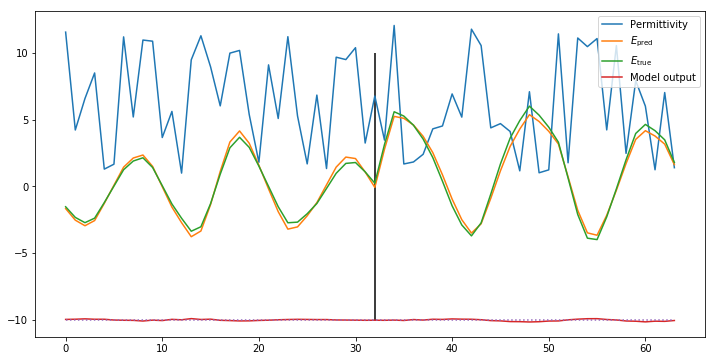

In [67]:
neural_solve_plot(epsilons, target_loss=1e-5, max_epochs=1e4)